In [72]:
!pip install tensorflow

In [130]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [132]:
btcdf = pd.read_csv('BTC.csv')

In [134]:
btcdf.shape

(2836, 7)

In [136]:
btcdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


In [138]:
btcdf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2831,2024-10-02,60836.324219,62357.687500,59996.949219,60632.785156,60632.785156,40762722398
2832,2024-10-03,60632.484375,61469.039062,59878.804688,60759.402344,60759.402344,36106447279
2833,2024-10-04,60754.625000,62465.992188,60459.941406,62067.476562,62067.476562,29585472513
2834,2024-10-05,62067.609375,62371.023438,61689.582031,62089.949219,62089.949219,13305410749
2835,2024-10-06,62084.988281,62959.570312,61833.148438,62818.953125,62818.953125,14776233667


In [140]:
btcdf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2836.000000,2836.000000,2836.000000,2836.000000,2836.000000,2.836000e+03
mean,23241.696396,23767.721452,22681.085905,23262.039342,23262.039342,2.287903e+10
std,19766.306933,20199.763573,19290.278300,19773.829052,19773.829052,1.888917e+10
min,775.177979,823.307007,755.755981,777.757019,777.757019,6.085170e+07
25%,7277.492554,7435.214966,7113.698975,7277.790405,7277.790405,7.730409e+09
50%,16601.785156,16804.058594,16284.663574,16603.525391,16603.525391,2.026586e+10
75%,37470.646484,38601.096680,36421.379883,37493.499023,37493.499023,3.252037e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [142]:
btcdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2836 non-null   object 
 1   Open       2836 non-null   float64
 2   High       2836 non-null   float64
 3   Low        2836 non-null   float64
 4   Close      2836 non-null   float64
 5   Adj Close  2836 non-null   float64
 6   Volume     2836 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.2+ KB


In [144]:
print('Total number of days:' , btcdf.shape[0])
print('Total number of fields present:' , btcdf.shape[1])

Total number of days: 2836
Total number of fields present: 7


In [146]:
print('Null Values: ', btcdf.isnull().values.sum())

Null Values:  0


In [148]:
closedf = btcdf[['Date', 'Close']]
print("shape of closed df: ", closedf.shape)

shape of closed df:  (2836, 2)


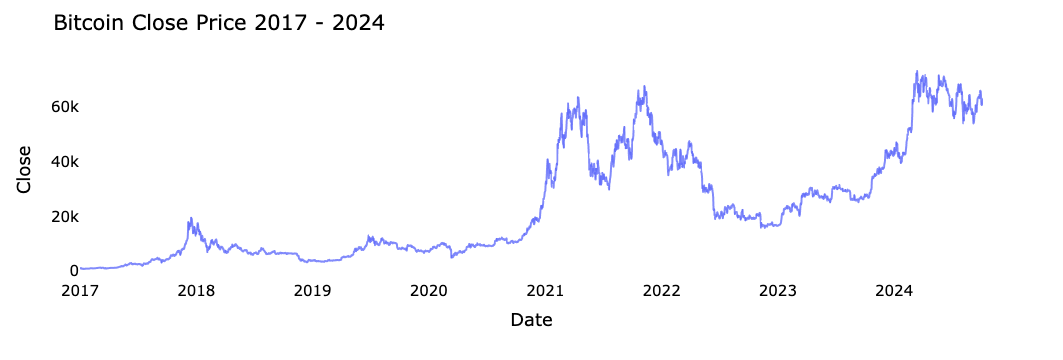

In [150]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=3, opacity=0.8, marker_line_color='blue')
fig.update_layout(title_text='Bitcoin Close Price 2017 - 2024', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [152]:
# Transform Data
del closedf['Date']

scaler = MinMaxScaler(feature_range=(0,1))
closedf['Close'] = scaler.fit_transform(np.array(closedf['Close']).reshape(-1,1))
print(closedf.shape)

(2836, 1)


/var/folders/4c/vyr3wb1x6tn91c28270fqk000000gn/T/ipykernel_4369/778609543.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [154]:
train_size = int(len(closedf) * 0.8)
test_size =  len(closedf) - train_size

train_data = closedf.iloc[0:train_size, :]
test_data = closedf.iloc[train_size:len(closedf), :]

print('Training Data: ', train_data.shape)
print('Test Data: ', test_data.shape)

Training Data:  (2268, 1)
Test Data:  (568, 1)


In [156]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset.iloc[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0]) 
    return np.array(dataX), np.array(dataY)

In [158]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (2252, 15)
y_train:  (2252,)
X_test:  (552, 15)
y_test:  (552,)


In [160]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2252, 15, 1)
X_test:  (552, 15, 1)


In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential()
model.add(Input(shape=(None, 1)))
model.add(LSTM(10, activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [164]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=1000, batch_size=32, verbose=1)

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0602 - val_loss: 0.0042
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0146
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0094
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5246e-04 - val_loss: 0.0016
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9191e-04 - val_loss: 0.0012
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8389e-04 - val_loss: 0.0012
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8314e-04 - val_loss: 0.0010
Epoch 12/1000
71/71 ━━━━━━━━━━━━━━━━

In [166]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step


((2252, 1), (552, 1))

In [168]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [170]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))

print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

print("Predicted Value after Training:", train_predict)
print("Predicted Value after Testing:", test_predict)


Train data RMSE:  921.830694796463
-------------------------------------------------------------------------------------
Test data RMSE:  1310.107139850038
Predicted Value after Training: [[  830.0358]
 [  836.1047]
 [  885.4139]
 ...
 [24666.885 ]
 [24458.941 ]
 [25415.012 ]]
Predicted Value after Testing: [[28259.725]
 [27777.43 ]
 [28313.176]
 [28191.139]
 [28071.28 ]
 [27948.02 ]
 [27994.89 ]
 [28438.697]
 [29921.592]
 [30250.135]
 [30199.082]
 [30610.412]
 [30585.82 ]
 [30430.51 ]
 [30459.889]
 [29330.09 ]
 [30769.09 ]
 [28572.734]
 [28331.852]
 [27194.502]
 [28014.78 ]
 [27492.184]
 [27582.006]
 [28487.871]
 [28447.146]
 [29731.54 ]
 [29245.98 ]
 [29408.793]
 [29322.016]
 [27946.916]
 [28959.346]
 [29062.887]
 [28864.826]
 [29716.592]
 [28745.883]
 [28501.182]
 [27611.744]
 [27747.746]
 [27641.143]
 [26932.26 ]
 [26835.246]
 [26810.219]
 [26987.115]
 [27265.309]
 [27038.846]
 [27518.613]
 [26757.445]
 [26982.861]
 [27198.725]
 [26723.076]
 [26930.078]
 [27313.99 ]
 [26197.604]
 [

In [172]:
model.save('bitcoin_lstm_model.h5')